### PCA on SVI 2020 data for Tennessee

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np
import itertools
from itertools import combinations
from scipy import spatial
import pickle as pickle
import gudhi
from pylab import *
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
import seaborn as sns
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from matplotlib import pyplot
import warnings

# Ignore FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)

#### Import the dataset

In [3]:
tnSviRaw = gpd.read_file('./data/processed data/SVI2020 TN counties with death rate/SVI2020_TN_counties_with_death_rate.shp')

In [4]:
# reaname od_deaths_ column to deaths_rate
tnSviRaw = tnSviRaw.rename(columns={'od_deaths_':'death_rate'})

##### Filtering the raw variables with overdose death rate

In [5]:
selectedVariables = ['EP_POV150','EP_UNEMP','EP_HBURD','EP_NOHSDP','EP_UNINSUR','EP_AGE65','EP_AGE17','EP_DISABL','EP_SNGPNT','EP_LIMENG','EP_MINRTY','EP_MUNIT','EP_MOBILE','EP_CROWD','EP_NOVEH','EP_GROUPQ','death_rate']

In [6]:
selectedVariablesWithoutY = ['EP_POV150','EP_UNEMP','EP_HBURD','EP_NOHSDP','EP_UNINSUR','EP_AGE65','EP_AGE17','EP_DISABL','EP_SNGPNT','EP_LIMENG','EP_MINRTY','EP_MUNIT','EP_MOBILE','EP_CROWD','EP_NOVEH','EP_GROUPQ']

In [7]:
# filter metro_svi_deaths dataframe to include only the selected variables and od_deaths_per_1000
tnSviMultipleVariablesDf = tnSviRaw[selectedVariables]

In [8]:
tnSviMultipleVariablesDf.head(3)

,EP_POV150,EP_UNEMP,EP_HBURD,EP_NOHSDP,EP_UNINSUR,EP_AGE65,EP_AGE17,EP_DISABL,EP_SNGPNT,EP_LIMENG,EP_MINRTY,EP_MUNIT,EP_MOBILE,EP_CROWD,EP_NOVEH,EP_GROUPQ,death_rate
0,24.6,5.5,22.4,11.4,8.9,19.9,21.1,20.8,5.7,0.8,11.4,8.3,13.0,1.9,4.8,1.7,0.823389
1,24.6,4.4,24.7,16.5,11.3,14.9,25.5,15.0,7.5,2.6,23.6,2.4,13.6,3.1,3.9,1.1,0.326951
2,31.7,7.2,18.8,16.6,7.7,23.9,19.8,27.6,5.3,0.0,4.6,0.5,29.4,0.6,6.0,1.2,0.309924


#### Applying PCA

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale 
from sklearn import model_selection
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler


In [10]:
#define predictor and response variables
X = tnSviMultipleVariablesDf.drop('death_rate', axis=1)
y = tnSviMultipleVariablesDf['death_rate']

In [11]:
#define scaler
scaler = StandardScaler()

The standard score of a sample x is calculated as:

z = (x - u) / s

where u is the mean of the training samples or zero if with_mean=False, and s is the standard deviation of the training samples or one if with_std=False.

The fit method is used to compute the mean and standard deviation of the input data, which will be used for later scaling. It is essentially the process of computing the parameters needed for the transformation. 

When you call fit, the StandardScaler calculates the mean and standard deviation of each feature in the training data. These parameters are stored in the mean_ and scale_ attributes of the scaler object

The fit_transform method not only computes the mean and standard deviation but also applies the transformation to the data. It centers and scales the data based on the computed mean and standard deviation.

It returns the transformed data, and the original data is not modified. The fit_transform method is often used when you have a training dataset and you want to both compute the scaling parameters and apply the transformation to the data in a single step.

In [12]:
# scaled_X
scaled_X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)


In [13]:
scaled_X

,EP_POV150,EP_UNEMP,EP_HBURD,EP_NOHSDP,EP_UNINSUR,EP_AGE65,EP_AGE17,EP_DISABL,EP_SNGPNT,EP_LIMENG,EP_MINRTY,EP_MUNIT,EP_MOBILE,EP_CROWD,EP_NOVEH,EP_GROUPQ
0,-0.455134,-0.198361,0.272093,-0.992969,-0.544523,0.248244,-0.035947,0.374557,-0.187674,0.132865,-0.248504,1.454362,-0.494484,0.170549,-0.257790,-0.304397
1,-0.455134,-0.748196,0.926135,0.264463,0.557085,-1.236845,1.866071,-1.037077,0.778958,2.629564,0.795788,-0.156646,-0.417663,1.725960,-0.659999,-0.431788
2,0.718366,0.651383,-0.751624,0.289119,-1.095327,1.436316,-0.597907,2.029576,-0.402481,-0.976779,-0.830568,-0.675445,1.605287,-1.514478,0.278489,-0.410556
3,0.073768,0.801337,-2.258763,1.521895,2.898002,-0.256686,-2.629608,2.248622,-1.315410,1.519920,-0.171466,-0.648140,1.566877,0.300167,-0.302480,1.011975
4,-1.446824,-0.548256,-0.410385,-1.190214,-0.406822,0.337350,-0.424996,-1.329139,-0.832095,0.132865,-0.419699,0.416764,-0.660929,0.429784,-0.883449,-0.346861
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90,0.205993,0.051563,-1.519412,0.880851,1.061989,0.040332,-1.635372,0.155510,0.241941,-0.560662,-0.325541,-0.484308,1.272397,1.466725,0.591318,1.946175
91,0.867120,-0.598241,0.243657,-0.672447,0.419384,-0.226984,-0.814046,0.179849,-0.133972,-0.421957,-0.068748,-0.211256,-0.353646,-0.866391,1.082907,0.884584
92,0.338219,-0.498271,0.101474,0.856196,0.465284,0.337350,0.309874,-0.404275,0.027134,-0.838073,-0.633693,-0.538919,0.004852,-0.477538,-0.525930,-0.346861
93,-3.198809,-1.697909,-1.348792,-2.620235,-2.242835,-1.741775,2.557714,-2.911142,-0.778393,0.271571,0.170925,1.700109,-1.928474,-0.996008,-1.419727,-0.622874


In [14]:
#define PCA model as many components
pca = PCA(n_components=16)

In [15]:
#fit PCA model to data
pca_transformed_data = pca.fit_transform(scaled_X)

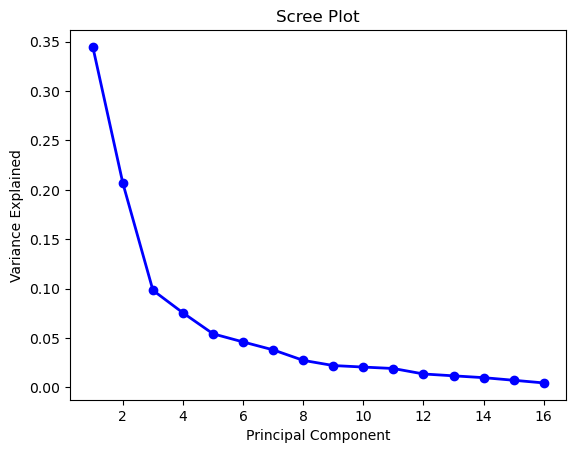

In [16]:
PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

In [17]:
# Check how much variance is explained by each principal components as a percentage
pca.explained_variance_ratio_*100

array([34.46881994, 20.66354723,  9.83009323,  7.54768472,  5.42794091,
        4.6053462 ,  3.80283613,  2.7403471 ,  2.21701129,  2.06306825,
        1.91711538,  1.3642914 ,  1.17581476,  0.99089215,  0.72740763,
        0.45778367])

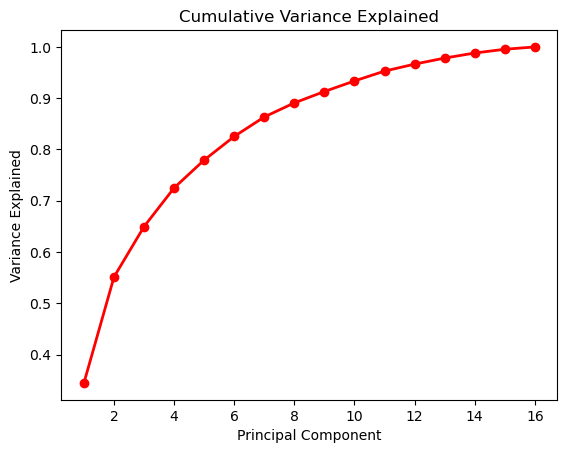

In [18]:
# plot cumulative variance explained
plt.plot(PC_values, np.cumsum(pca.explained_variance_ratio_), 'ro-', linewidth=2)
plt.title('Cumulative Variance Explained')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

##### Now we explore the features using PCA for different number of components

In [17]:
scaled_pca2 = PCA(n_components=2).fit(scaled_X)
X_std_transformed = scaled_pca2.transform(scaled_X)

In [18]:
scaled_pca3 = PCA(n_components=3).fit(scaled_X)
X_std_transformed3 = scaled_pca2.transform(scaled_X)

In [19]:
first_pca_component = pd.DataFrame(
    scaled_pca2.components_[0], index=X.columns, columns=["scalled principal component"]
)

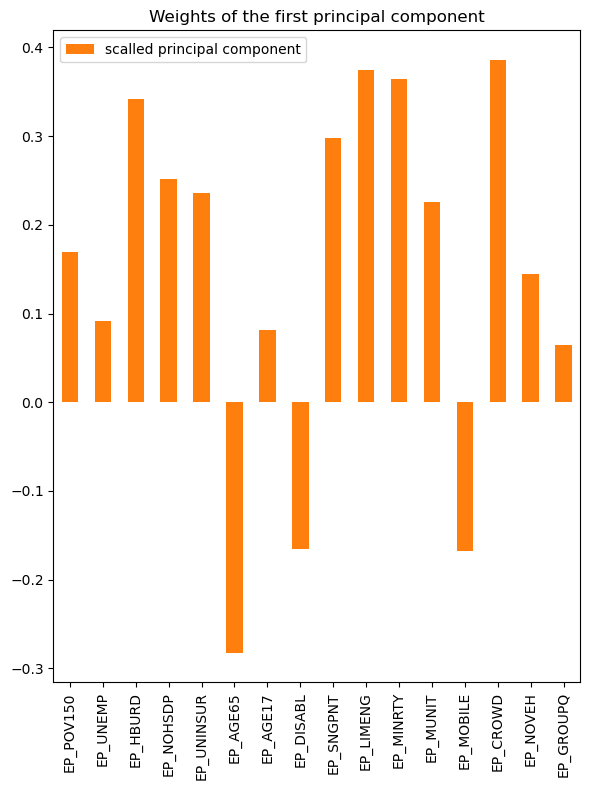

In [21]:
first_pca_component.plot.bar(
    title="Weights of the first principal component", figsize=(6, 8), color="C1"
)

_ = plt.tight_layout()